In [1]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

# indices = np.arange(X.shape[0])
# train_idx, val_idx = train_test_split(indices, test_size=0.8, stratify=y, random_state=seed)

# fold = np.zeros(X.shape[0])
# fold[train_idx] = -1

# ps = PredefinedSplit(fold)
# ps.get_n_splits()

# for i, (train_index, test_index) in enumerate(ps.split()):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

# X_val = X[val_idx,:]
# y_val = y[val_idx]
# X_train = X[train_idx,:]
# y_train = y[train_idx]

train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

EX1) #Righe: 617002 #Colonne: 46


In [2]:
print(X_val.shape)

(61699, 44)


In [3]:
# # Convert X_train and X_val to DataFrames for easier comparison
# X_train_df = pd.DataFrame(X_train)
# X_val_df = pd.DataFrame(X_val)

# # Check for duplicates between the training and validation sets
# duplicates = X_val_df[X_val_df.isin(X_train_df.to_dict(orient='list')).all(axis=1)]

# # Print the number of duplicates found
# print(f"Number of duplicates found: {duplicates.shape[0]}")
# print(f"val length: {len(val_idx)} ({duplicates.shape[0]/len(val_idx)*100:.2f}%)")

In [4]:
## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# ## PCA plotting
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1, 2)

# axs[0].scatter(X_train[:,0], X_train[:,1], c=y_train)
# axs[1].scatter(X_val[:,0], X_val[:,1], c=y_val)
# plt.show()

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

In [5]:
## KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

# best_score = 0
# best_k = -1
# best_clf = None

list_clf = []
list_acc_train = []
list_rec_train = []
list_pre_train = []
list_f1_train = []

for k in np.arange(1,100002,500):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train.append(score_f1)

    score = clf.score(X_test, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf.append(clf)

# print("\nBest K = {:d} with score = {:.4f}".format(best_k, best_score))
# cm = confusion_matrix(y_test, best_clf.predict(X_test), labels=best_clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
# disp.plot()

K=1
  Accuracy - 0.9989
  F1 - 0.9989
K=501
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1001
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1501
  Accuracy - 0.9640
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2001
  Accuracy - 0.9524
  F1 - 0.9494


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2501
  Accuracy - 0.9422
  F1 - 0.9379


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3001
  Accuracy - 0.9383
  F1 - 0.9333


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3501
  Accuracy - 0.9352
  F1 - 0.9295


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4001
  Accuracy - 0.9315
  F1 - 0.9250


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4501
  Accuracy - 0.9268
  F1 - 0.9200


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5001
  Accuracy - 0.9247
  F1 - 0.9175


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5501
  Accuracy - 0.9218
  F1 - 0.9141


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6001
  Accuracy - 0.9158
  F1 - 0.9045


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6501
  Accuracy - 0.9135
  F1 - 0.9017


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=7001
  Accuracy - 0.9110
  F1 - 0.8980


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

In [7]:
list_acc_val = []
list_rec_val = []
list_pre_val = []
list_f1_val = []

for clf in list_clf:
    val_pred = clf.predict(X_val)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1
  Accuracy - 0.0245
  F1 - 0.0023


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


501
  Accuracy - 0.2139
  F1 - 0.2479


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1001
  Accuracy - 0.3253
  F1 - 0.3754


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1501
  Accuracy - 0.3390
  F1 - 0.3955


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2001
  Accuracy - 0.3418
  F1 - 0.4002


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2501
  Accuracy - 0.3471
  F1 - 0.4069


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3001
  Accuracy - 0.3476
  F1 - 0.4076


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3501
  Accuracy - 0.3484
  F1 - 0.4087


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4001
  Accuracy - 0.3462
  F1 - 0.4054


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4501
  Accuracy - 0.3476
  F1 - 0.4069


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5001
  Accuracy - 0.3494
  F1 - 0.4088


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5501
  Accuracy - 0.3493
  F1 - 0.4088


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6001
  Accuracy - 0.3495
  F1 - 0.4089


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6501
  Accuracy - 0.3496
  F1 - 0.4089
7001
  Accuracy - 0.3498
  F1 - 0.4091


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
list_acc_train.pop()

0.909948458621025

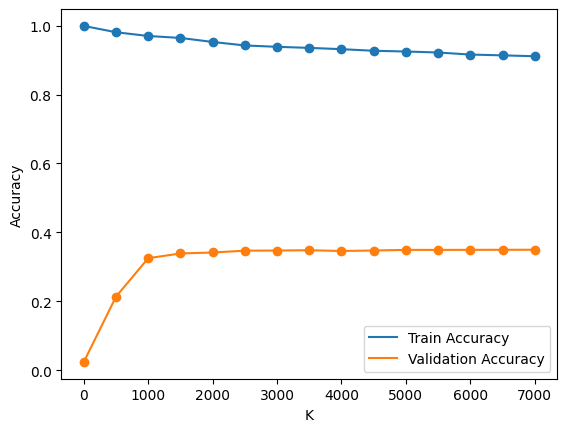

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1, 7002, 500), list_acc_train, label="Train Accuracy")
plt.scatter(range(1, 7002, 500), list_acc_train)
plt.scatter(range(1, 7002, 500), list_acc_val)
plt.plot(range(1, 7002, 500), list_acc_val, label="Validation Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
list_f1_train.pop()

0.896591413235814

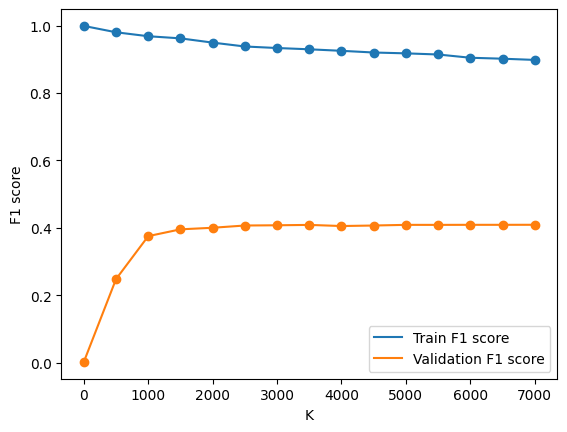

In [32]:
plt.plot(range(1, 7002, 500), list_f1_train, label="Train F1 score")
plt.scatter(range(1, 7002, 500), list_f1_train)
plt.scatter(range(1, 7002, 500), list_f1_val)
plt.plot(range(1, 7002, 500), list_f1_val, label="Validation F1 score")
plt.xlabel('K')
plt.ylabel('F1 score')
plt.legend()
plt.show()

---

In [9]:
## WITH PCA

list_clf_pca = []
list_acc_train_pca = []
list_rec_train_pca = []
list_pre_train_pca = []
list_f1_train_pca = []

for k in np.arange(1,7002,500):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_pca, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_pca.append(clf)

K=1
  Accuracy - 0.9989
  F1 - 0.9989
K=501
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1001
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1501
  Accuracy - 0.9640
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2001
  Accuracy - 0.9524
  F1 - 0.9494


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2501
  Accuracy - 0.9422
  F1 - 0.9379


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3001
  Accuracy - 0.9383
  F1 - 0.9333


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3501
  Accuracy - 0.9352
  F1 - 0.9295


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4001
  Accuracy - 0.9315
  F1 - 0.9250


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4501
  Accuracy - 0.9268
  F1 - 0.9200


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5001
  Accuracy - 0.9247
  F1 - 0.9175


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5501
  Accuracy - 0.9218
  F1 - 0.9141


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6001
  Accuracy - 0.9158
  F1 - 0.9045


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6501
  Accuracy - 0.9135
  F1 - 0.9017


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=7001
  Accuracy - 0.9110
  F1 - 0.8980


In [15]:
list_acc_val_pca = []
list_rec_val_pca = []
list_pre_val_pca = []
list_f1_val_pca = []

for clf in list_clf_pca:
    val_pred = clf.predict(X_val_pca)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1
  Accuracy - 0.0245
  F1 - 0.0023


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


501
  Accuracy - 0.2139
  F1 - 0.2479


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1001
  Accuracy - 0.3253
  F1 - 0.3754


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1501
  Accuracy - 0.3390
  F1 - 0.3955


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2001
  Accuracy - 0.3418
  F1 - 0.4002


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2501
  Accuracy - 0.3471
  F1 - 0.4069


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3001
  Accuracy - 0.3476
  F1 - 0.4076


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3501
  Accuracy - 0.3484
  F1 - 0.4087


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4001
  Accuracy - 0.3462
  F1 - 0.4054


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4501
  Accuracy - 0.3476
  F1 - 0.4069


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5001
  Accuracy - 0.3494
  F1 - 0.4088


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5501
  Accuracy - 0.3493
  F1 - 0.4088


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6001
  Accuracy - 0.3495
  F1 - 0.4089


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6501
  Accuracy - 0.3496
  F1 - 0.4089
7001
  Accuracy - 0.3498
  F1 - 0.4091


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


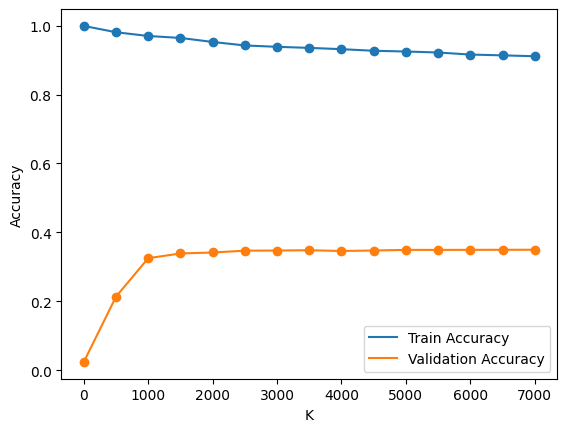

In [33]:
plt.plot(range(1, 7002, 500), list_acc_train_pca, label="Train Accuracy")
plt.scatter(range(1, 7002, 500), list_acc_train_pca)
plt.scatter(range(1, 7002, 500), list_acc_val_pca)
plt.plot(range(1, 7002, 500), list_acc_val_pca, label="Validation Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

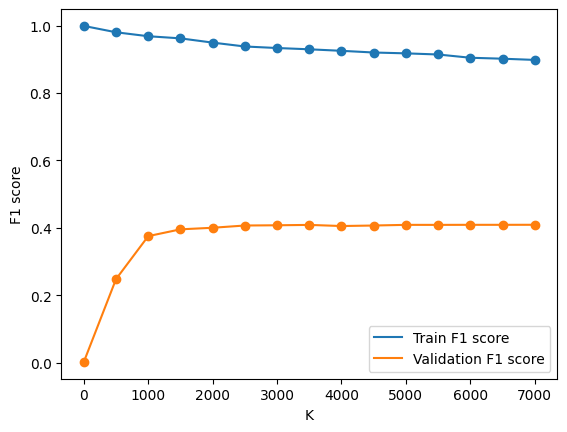

In [34]:
plt.plot(range(1, 7002, 500), list_f1_train_pca, label="Train F1 score")
plt.scatter(range(1, 7002, 500), list_f1_train_pca)
plt.scatter(range(1, 7002, 500), list_f1_val_pca)
plt.plot(range(1, 7002, 500), list_f1_val_pca, label="Validation F1 score")
plt.xlabel('K')
plt.ylabel('F1 score')
plt.legend()
plt.show()

---

In [12]:
## WITH LDA

list_clf_lda = []
list_acc_train_lda = []
list_rec_train_lda = []
list_pre_train_lda = []
list_f1_train_lda = []

for k in np.arange(1,7002,500):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)

    y_pred = clf.predict(X_test_lda)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_lda.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_lda.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_lda.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_lda.append(score_f1)

    score = clf.score(X_test_lda, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_lda.append(clf)

K=1
  Accuracy - 0.9986
  F1 - 0.9986
K=501
  Accuracy - 0.9843
  F1 - 0.9840
K=1001
  Accuracy - 0.9762
  F1 - 0.9749


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1501
  Accuracy - 0.9701
  F1 - 0.9681


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2001
  Accuracy - 0.9646
  F1 - 0.9623


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2501
  Accuracy - 0.9619
  F1 - 0.9597


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3001
  Accuracy - 0.9615
  F1 - 0.9594


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=3501
  Accuracy - 0.9596
  F1 - 0.9572


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4001
  Accuracy - 0.9546
  F1 - 0.9506


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=4501
  Accuracy - 0.9543
  F1 - 0.9502


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5001
  Accuracy - 0.9539
  F1 - 0.9497


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=5501
  Accuracy - 0.9536
  F1 - 0.9493


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6001
  Accuracy - 0.9536
  F1 - 0.9492


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=6501
  Accuracy - 0.9536
  F1 - 0.9491


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=7001
  Accuracy - 0.9538
  F1 - 0.9492


In [14]:
list_acc_val_lda = []
list_rec_val_lda = []
list_pre_val_lda = []
list_f1_val_lda = []

for clf in list_clf_lda:
    val_pred = clf.predict(X_val_lda)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_lda.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_lda.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_lda.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_lda.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1
  Accuracy - 0.0318
  F1 - 0.0056


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


501
  Accuracy - 0.0268
  F1 - 0.0029


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1001
  Accuracy - 0.0258
  F1 - 0.0026


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1501
  Accuracy - 0.0263
  F1 - 0.0039


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2001
  Accuracy - 0.0267
  F1 - 0.0051


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2501
  Accuracy - 0.0269
  F1 - 0.0057


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3001
  Accuracy - 0.0268
  F1 - 0.0055


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3501
  Accuracy - 0.0264
  F1 - 0.0048


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4001
  Accuracy - 0.0262
  F1 - 0.0044


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4501
  Accuracy - 0.0260
  F1 - 0.0041


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5001
  Accuracy - 0.0259
  F1 - 0.0038


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5501
  Accuracy - 0.0259
  F1 - 0.0038


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6001
  Accuracy - 0.0259
  F1 - 0.0038


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6501
  Accuracy - 0.0259
  F1 - 0.0038
7001
  Accuracy - 0.0258
  F1 - 0.0036


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


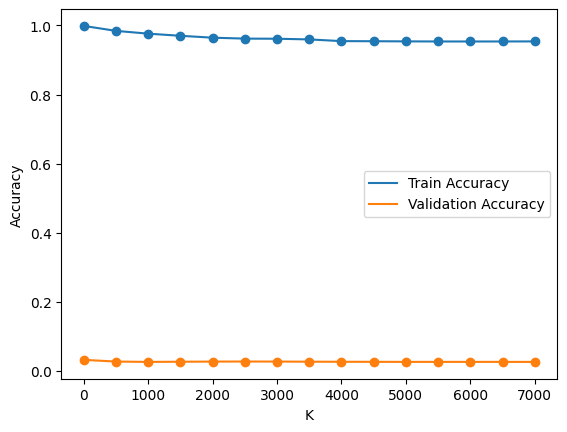

In [22]:
plt.plot(range(1, 7002, 500), list_acc_train_lda, label="Train Accuracy")
plt.scatter(range(1, 7002, 500), list_acc_train_lda)
plt.scatter(range(1, 7002, 500), list_acc_val_lda)
plt.plot(range(1, 7002, 500), list_acc_val_lda, label="Validation Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

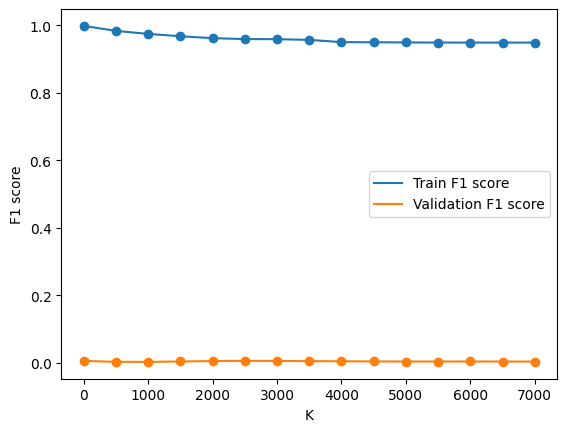

In [23]:
plt.plot(range(1, 7002, 500), list_f1_train_lda, label="Train F1 score")
plt.scatter(range(1, 7002, 500), list_f1_train_lda)
plt.scatter(range(1, 7002, 500), list_f1_val_lda)
plt.plot(range(1, 7002, 500), list_f1_val_lda, label="Validation F1 score")
plt.xlabel('K')
plt.ylabel('F1 score')
plt.legend()
plt.show()

[1.00000000e+00 1.99600798e-03 9.99000999e-04 6.66222518e-04
 4.99750125e-04 3.99840064e-04 3.33222259e-04 2.85632676e-04
 2.49937516e-04 2.22172850e-04 1.99960008e-04 1.81785130e-04
 1.66638894e-04 1.53822489e-04 1.42836738e-04]
[0.97549393 0.78610674 0.67467868 0.66096695 0.65816302 0.65291172
 0.65244169 0.6516151  0.65378693 0.65240928 0.65061022 0.65069126
 0.65046435 0.6503509  0.65017261]
[0.00111835 0.01944958 0.03029272 0.03596551 0.04763526 0.05778145
 0.06170378 0.0647833  0.06854355 0.07316283 0.07530228 0.07821972
 0.08416804 0.08646958 0.08904665]


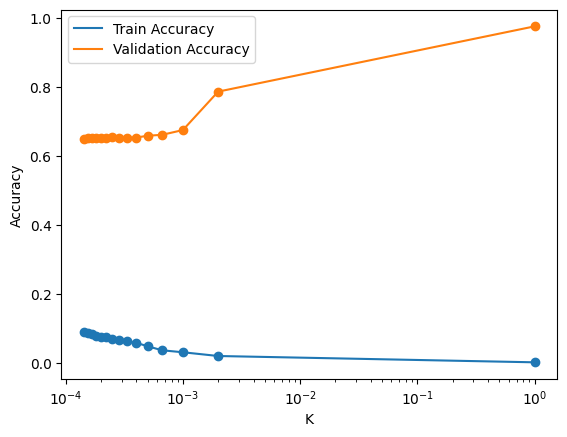

In [51]:
x_ax = 1/np.arange(1,7002,500)
print(x_ax)

err_rate_val = 1 - np.array(list_acc_val)
print(err_rate_val)

err_rate_train = 1 - np.array(list_acc_train)
print(err_rate_train)

plt.plot(x_ax, err_rate_train, label="Train Accuracy")
plt.scatter(x_ax, err_rate_train)
plt.scatter(x_ax, err_rate_val)
plt.plot(x_ax, err_rate_val, label="Validation Accuracy")
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

In [47]:
## save data
import pickle

with open('knn.pkl', 'wb') as f:
    pickle.dump([list_clf, list_acc_train, list_rec_train, list_pre_train, list_f1_train, list_acc_val, list_rec_val, list_pre_val, list_f1_val], f)
    pickle.dump([list_clf_pca, list_acc_train_pca, list_rec_train_pca, list_pre_train_pca, list_f1_train_pca, list_acc_val_pca, list_rec_val_pca, list_pre_val_pca, list_f1_val_pca], f)
    pickle.dump([list_clf_lda, list_acc_train_lda, list_rec_train_lda, list_pre_train_lda, list_f1_train_lda, list_acc_val_lda, list_rec_val_lda, list_pre_val_lda, list_f1_val_lda], f)

In [62]:
import matplotlib.pyplot as plt
import numpy as np

x_ax = 1/np.arange(1,7002,500)
x_ax = x_ax[1:]
print(x_ax)

[0.00199601 0.000999   0.00066622 0.00049975 0.00039984 0.00033322
 0.00028563 0.00024994 0.00022217 0.00019996 0.00018179 0.00016664
 0.00015382 0.00014284]


[0.78610674 0.67467868 0.66096695 0.65816302 0.65291172 0.65244169
 0.6516151  0.65378693 0.65240928 0.65061022 0.65069126 0.65046435
 0.6503509  0.65017261]
[0.01944958 0.03029272 0.03596551 0.04763526 0.05778145 0.06170378
 0.0647833  0.06854355 0.07316283 0.07530228 0.07821972 0.08416804
 0.08646958 0.08904665]


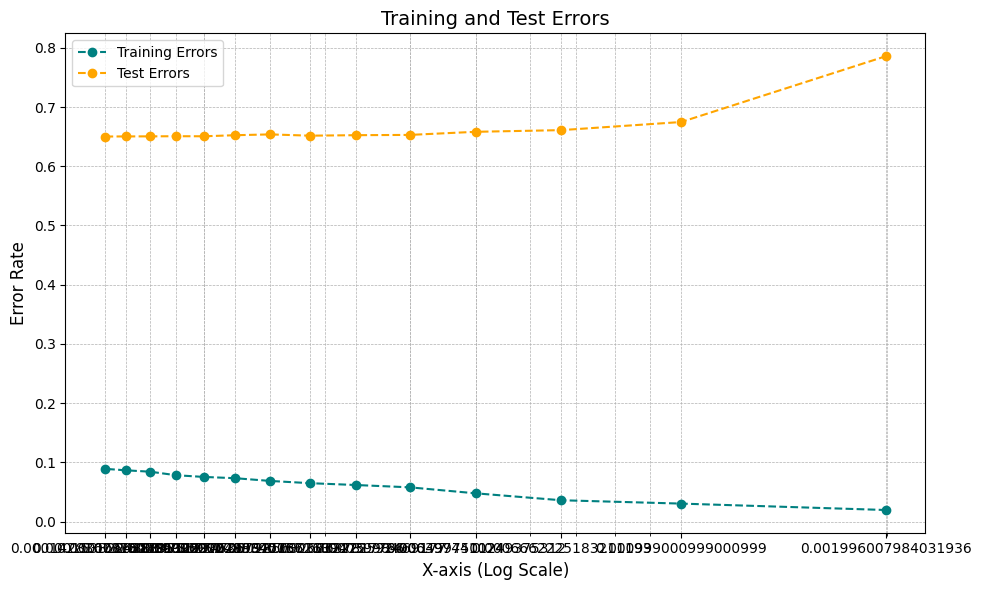

In [63]:
err_rate_val = 1 - np.array(list_acc_val)
err_rate_val = err_rate_val[1:]
print(err_rate_val)

err_rate_train = 1 - np.array(list_acc_train)
err_rate_train = err_rate_train[1:]
print(err_rate_train)

x_values = x_ax
training_errors = err_rate_train
test_errors = err_rate_val

plt.figure(figsize=(10, 6))
plt.plot(x_values, training_errors, linestyle='--', marker='o', color='teal', label='Training Errors')
plt.plot(x_values, test_errors, linestyle='--', marker='o', color='orange', label='Test Errors')
plt.xscale('log')
plt.xticks(x_values, labels=[str(v) for v in x_values])
plt.xlabel('X-axis (Log Scale)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Training and Test Errors', fontsize=14)
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

[0.97317623 0.97419731 0.97367867 0.97325727 0.97306277 0.97320864
 0.97358142 0.97379212 0.9739542  0.97411627 0.97411627 0.97410007
 0.97413248 0.97422973]
[0.01570553 0.02377711 0.02993614 0.03543065 0.03810496 0.03847775
 0.04043891 0.04538235 0.04567409 0.04611171 0.04638724 0.04643587
 0.04638724 0.04619275]


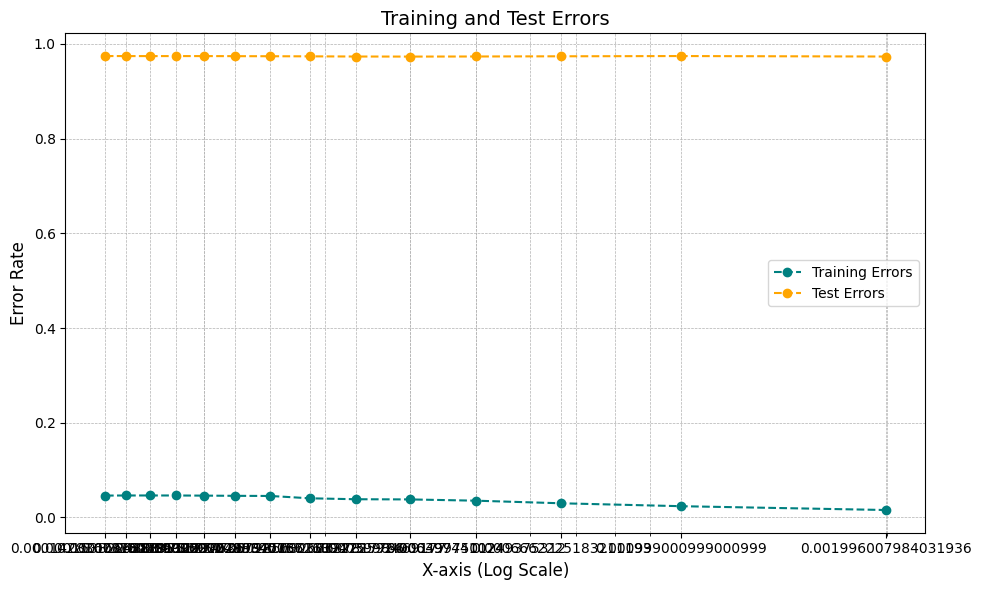

In [64]:
err_rate_val = 1 - np.array(list_acc_val_lda)
err_rate_val = err_rate_val[1:]
print(err_rate_val)

err_rate_train = 1 - np.array(list_acc_train_lda)
err_rate_train = err_rate_train[1:]
print(err_rate_train)

x_values = x_ax
training_errors = err_rate_train
test_errors = err_rate_val

plt.figure(figsize=(10, 6))
plt.plot(x_values, training_errors, linestyle='--', marker='o', color='teal', label='Training Errors')
plt.plot(x_values, test_errors, linestyle='--', marker='o', color='orange', label='Test Errors')
plt.xscale('log')
plt.xticks(x_values, labels=[str(v) for v in x_values])
plt.xlabel('X-axis (Log Scale)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Training and Test Errors', fontsize=14)
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

[0.78610674 0.67467868 0.66096695 0.65816302 0.65291172 0.65244169
 0.6516151  0.65378693 0.65240928 0.65061022 0.65069126 0.65046435
 0.6503509  0.65017261]
[0.01944958 0.03029272 0.03596551 0.04763526 0.05778145 0.06170378
 0.0647833  0.06854355 0.07316283 0.07530228 0.07821972 0.08416804
 0.08646958 0.08904665]


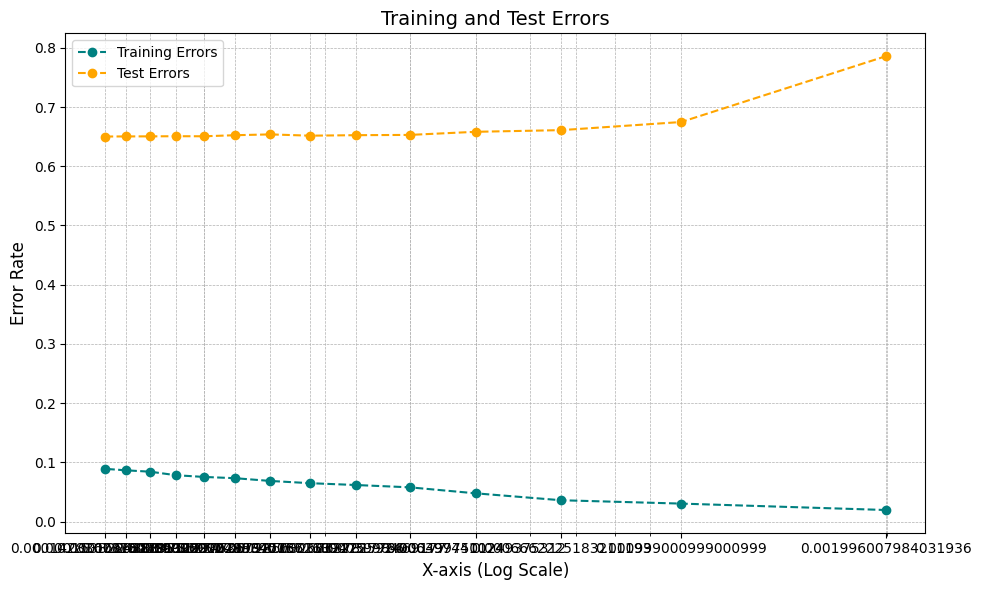

In [65]:
err_rate_val = 1 - np.array(list_acc_val_pca)
err_rate_val = err_rate_val[1:]
print(err_rate_val)

err_rate_train = 1 - np.array(list_acc_train_pca)
err_rate_train = err_rate_train[1:]
print(err_rate_train)

x_values = x_ax
training_errors = err_rate_train
test_errors = err_rate_val

plt.figure(figsize=(10, 6))
plt.plot(x_values, training_errors, linestyle='--', marker='o', color='teal', label='Training Errors')
plt.plot(x_values, test_errors, linestyle='--', marker='o', color='orange', label='Test Errors')
plt.xscale('log')
plt.xticks(x_values, labels=[str(v) for v in x_values])
plt.xlabel('X-axis (Log Scale)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Training and Test Errors', fontsize=14)
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()